In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysta
import stc

import os

%load_ext autoreload
%autoreload 2

In [14]:
def load_sta_stat(dataset_name, folder_name="data", tap = 8): 
    
    
#     stim, spike_train, info = pysta.load_data(dataset_name, folder_name)


    
    folder_name = "{}_tap{}_sta".format(dataset_name, tap)
    sta_stat = pd.read_csv(os.path.join(folder_name, "stat_more.csv"))

    # subtract center from min,max
    sta_stat["min"] -= 0.5
    sta_stat["max"] -= 0.5

    sta_stat["peak_diff"] = sta_stat["max"] - sta_stat["min"] 

    # calc polarity
    pos = np.abs(sta_stat["max"])
    neg = np.abs(sta_stat["min"])

    #sta_result["polarity"] = (pos - neg) / np.sqrt(pos) / np.sqrt(neg)
    # sta_result["polarity"] = (pos - neg) / np.minimum(pos, neg)
    sta_stat["polarity"] = np.maximum(pos, neg) / np.minimum(pos, neg) * np.sign(pos-neg)

    # calc d_prime
    sta_stat["PSNR"] = (sta_stat["max"] - sta_stat["min"]) / sta_stat["sigma"]


    return sta_stat
    
sta_stat1 = load_sta_stat("20180618")
sta_stat2 = load_sta_stat("20180621")
sta_stat3 = load_sta_stat("20180626")
sta_stat4 = load_sta_stat("20180828")

In [23]:
# combine all patches 
sta_stat = pd.concat([sta_stat1, sta_stat2, sta_stat3, sta_stat4])

print("total = ", len(sta_stat))
print(sta_stat["cell_type"].value_counts())
print(sta_stat["cell_type"].value_counts() / len(sta_stat))

total =  483
OFF        199
unknown    168
ON         116
Name: cell_type, dtype: int64
OFF        0.412008
unknown    0.347826
ON         0.240166
Name: cell_type, dtype: float64


In [24]:
x_data = np.log10(sta_stat["num_spikes"])
y_data = np.log10(sta_stat['sigma']**2)

# correlation coeff
rho = np.corrcoef(x_data, y_data)[0,1]
print(rho)

-0.8525923397600573


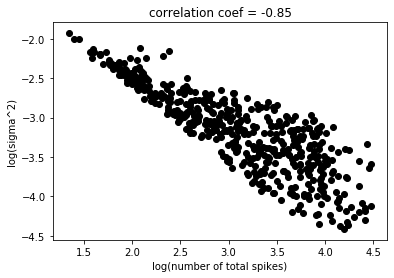

In [26]:
plt.scatter(x_data, y_data, marker='o', color='k')
# plt.xlabel('log(number of samples)')
plt.xlabel('log(number of total spikes)')
plt.ylabel('log(sigma^2)')

plt.title('correlation coef = {:.2f}'.format(rho))

plt.savefig("figure/combined_n_vs_sig.pdf")
plt.savefig("figure/combined_n_vs_sig.png")

[-0.60871437 -1.28478194]
[[ 0.0002894  -0.00089682]
 [-0.00089682  0.00293349]]


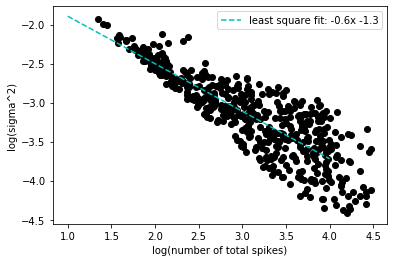

In [29]:
# fit to ax + b
# plt.figure(figsize=(8,6))
plt.scatter(x_data, y_data, marker='o', color='k')
# plt.xlabel('log(number of samples)')
plt.xlabel('log(number of total spikes)')
plt.ylabel('log(sigma^2)')

from scipy import optimize

def fit_func(x, a, b):
    return a * x + b

params, params_covariance = optimize.curve_fit(fit_func, x_data, y_data,
                                               p0=[-1, 0])

# def fit_func(x, b):
#     return -1 * x + b
# params, params_covariance = optimize.curve_fit(fit_func, x_data, y_data,
#                                                p0=[0])
print(params)
print(params_covariance)

x = np.linspace(1,4, 40)
plt.plot(x, fit_func(x, *params), 'c--', label='least square fit: {:.1f}x {:.1f}'.format(*params))
# plt.plot(x, fit_func(x, *params), 'k--', label='least square fit: -x {:.1f}'.format(*params))

plt.legend()

plt.savefig("figure/combined_n_vs_sig_fit.pdf")
plt.savefig("figure/combined_n_vs_sig_fit.png")

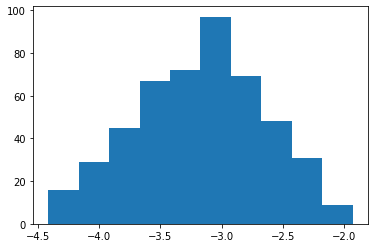

In [30]:
# select x by quantizing sigma and take minimum of x
# y_bins = np.linspace(-2.3, -0.8, 30)
# plt.hist(y_data, y_bins)
y_bins = np.linspace(-4.5, -1.5, 30)
plt.hist(y_data)

# fit selected samples to a x + b
x_selected = list()
y_selected = list()
idx_selected = list()

for i in range(len(y_bins)-1):
    idx = np.logical_and(y_data >= y_bins[i], y_data < y_bins[i+1])
    cnt = np.sum(idx)
    
    if cnt >0:
        xs = np.array(x_data[idx])
        ys = np.array(y_data[idx])

        # take min of x
        min_x = np.min(xs)        
        arg_min_x = np.argmin(xs)
        
        x_selected.append(min_x)
        y_selected.append(ys[arg_min_x])        
#         print(np.where(idx)[0], arg_min_x)
        idx_selected.append(np.where(idx)[0][arg_min_x])

x_selected = np.array(x_selected)
y_selected = np.array(y_selected)

-0.9856345959814391


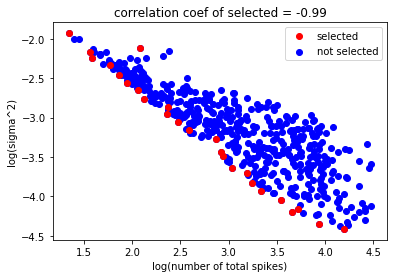

In [31]:
# cross correlation
rho_selected = np.corrcoef(x_selected, y_selected)[0,1]
print(rho_selected)

plt.scatter(x_data, y_data, color='b', label='not selected')
plt.plot(x_selected, y_selected, 'ro', label='selected')
plt.legend()

plt.xlabel('log(number of total spikes)')
# plt.xlabel('log(number of samples)')
plt.ylabel('log(sigma^2)')

plt.title('correlation coef of selected = {:.2f}'.format(rho_selected))

plt.savefig("figure/combined_n_vs_sig_selected.pdf")
plt.savefig("figure/combined_n_vs_sig_selected.png")

[-0.93846507 -0.6840476 ]
[[ 0.00112433 -0.00300112]
 [-0.00300112  0.0087104 ]]


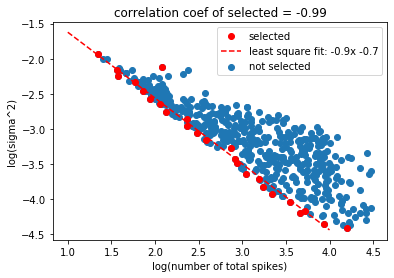

In [32]:
# fit selected samples to ax+b
def fit_func(x, a, b):
    return a * x + b

params, params_covariance = optimize.curve_fit(fit_func, x_selected, y_selected,
                                               p0=[-1, 0])
# def fit_func(x, b):
#     return - x + b

# params, params_covariance = optimize.curve_fit(fit_func, x_selected, y_selected,
#                                                p0=[0])

print(params)
print(params_covariance)


# plt.figure(figsize=(8,6))
plt.scatter(x_data, y_data, label='not selected')
plt.plot(x_selected, y_selected, 'ro', label='selected')

x = np.linspace(1,4, 40)
plt.plot(x, fit_func(x, *params), 'r--', label='least square fit: {:.1f}x {:.1f}'.format(*params))

plt.xlabel('log(number of total spikes)')
# plt.xlabel('log(number of samples)')
plt.ylabel('log(sigma^2)')
plt.legend()


plt.title('correlation coef of selected = {:.2f}'.format(rho_selected))

plt.savefig("figure/combined_n_vs_sig_fit_selected.pdf")
plt.savefig("figure/combined_n_vs_sig_fit_selected.png")

In [35]:
# helper function to plot histograms of a column by cell_type
def plot_histogram_by_cell_type(clusters, col_name, alpha=0.5, separate_figure=False, XLIM=None):
    if separate_figure:
        plt.figure()
        
    idx_on = clusters["cell_type"] == "ON"
    clusters.loc[idx_on, col_name].hist(alpha=alpha, color='r')
    
    if XLIM is not None:
        plt.xlim(XLIM)
    
    if separate_figure:
        plt.xlabel(col_name + " (ON)")
        plt.ylabel("count")
        plt.show()

        
    if separate_figure:
        plt.figure()

    idx_on = clusters["cell_type"] == "OFF"
    clusters.loc[idx_on, col_name].hist(alpha=alpha, color='b')
    
    if XLIM is not None:
        plt.xlim(XLIM)

    if separate_figure:
        plt.xlabel(col_name + " (OFF)")
        plt.ylabel("count")
        plt.show()
    
    
    if separate_figure:
        plt.figure()
        
    idx_unknown = clusters["cell_type"] == "unknown"
    clusters.loc[idx_unknown, col_name].hist(alpha=alpha, color='k')
    
    if XLIM is not None:
        plt.xlim(XLIM)

    if separate_figure:
        plt.xlabel(col_name + " (unknown)")
        plt.ylabel("count")
        plt.show()
    else: # plot once
        plt.xlabel(col_name)
        plt.ylabel("count")
        plt.legend(["ON", "OFF", "unknown"])

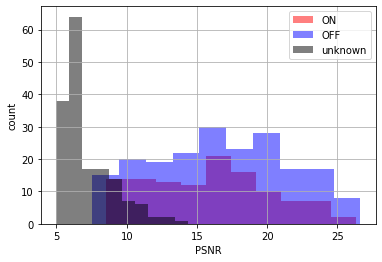

In [37]:
plot_histogram_by_cell_type(sta_stat, "PSNR")

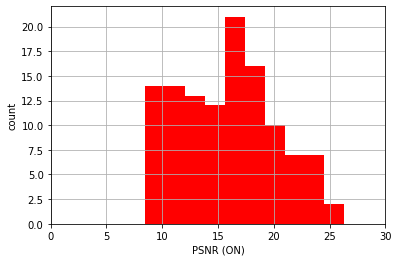

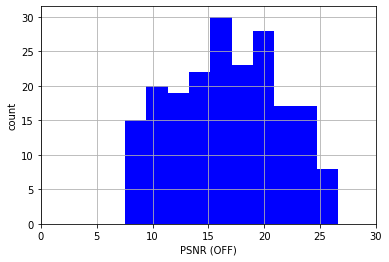

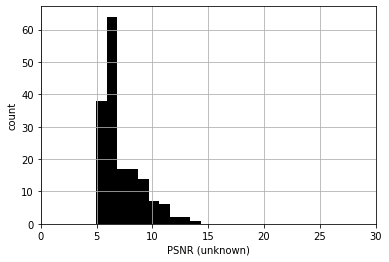

In [36]:
plot_histogram_by_cell_type(sta_stat, "PSNR", alpha=1, separate_figure=True, XLIM=[0,30])

Text(0, 0.5, 'number of spikes')

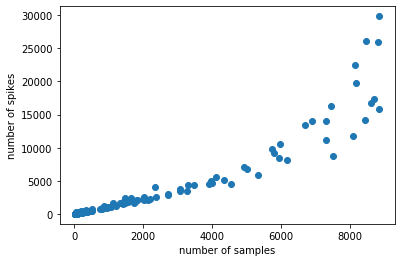

In [38]:
idx_unknown = sta_stat["cell_type"]=="unknown"
sta_stat_unknown = sta_stat.loc[idx_unknown]

plt.scatter(sta_stat_unknown["num_samples"], sta_stat_unknown["num_spikes"])
plt.xlabel('number of samples')
plt.ylabel('number of spikes')